## Encoding cyclical continuous features - 24-hour time
Author: Ian London  
Source: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def rand_times(n, seed):
    """Generate n rows of random 24-hour times (seconds past midnight)"""
    np.random.seed(seed)
    rand_seconds = np.random.randint(0, 24*60*60, n)
    return pd.DataFrame(data=dict(
            seconds=rand_seconds, 
            minutes=rand_seconds/60, 
            hour=rand_seconds/3600)
        ).\
        sort_values('seconds').\
        reset_index(drop=True)

In [3]:
df = rand_times(n=1000, seed=123)
print(df.head(5))
print(df.tail(5))

   seconds   minutes      hour
0       70  1.166667  0.019444
1      109  1.816667  0.030278
2      268  4.466667  0.074444
3      321  5.350000  0.089167
4      389  6.483333  0.108056
     seconds      minutes       hour
995    86024  1433.733333  23.895556
996    86176  1436.266667  23.937778
997    86275  1437.916667  23.965278
998    86280  1438.000000  23.966667
999    86349  1439.150000  23.985833


Without any proper encoding the values are laid out on a linear scale.   
This is undesirable: we want our machine learning model to see that 23:50 and 00:10 are 20 minutes apart, but as it stands, those times will appear to be 23 hours and 40 minutes apart!

In [4]:
df_linear = df.loc[:, ['seconds']].copy()
df_linear['center'] = 0

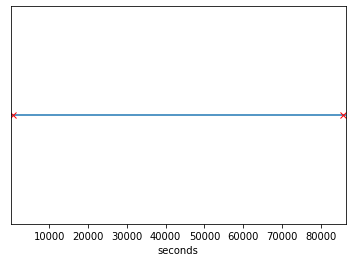

In [5]:
ax = df_linear.plot(x='seconds', y='center')
ax.axes.yaxis.set_visible(False)
ax.get_legend().remove()

# 10 min after midnight (00:10)
ax.plot(10*60, 0, 'xr')

# 10 min before  midnight (23:50)
ax.plot((24*60*60) - (10*60), 0, 'xr')

plt.show()

Thus this needs to be represented in a cyclic manner!

## Transformation into 2 dimensions
- Create two new features
    - a sine transformation and
    - a cosine transformation
- use the two new features instead of the original raw seconds

In [6]:
total_no_of_seconds_in_a_day = 24*60*60
df['sin_seconds'] = np.sin(2 * np.pi * df.seconds/total_no_of_seconds_in_a_day)
df['cosine_seconds'] = np.cos(2 * np.pi * df.seconds/total_no_of_seconds_in_a_day)

print(df.head())

   seconds   minutes      hour  sin_seconds  cosine_seconds
0       70  1.166667  0.019444     0.005091        0.999987
1      109  1.816667  0.030278     0.007927        0.999969
2      268  4.466667  0.074444     0.019488        0.999810
3      321  5.350000  0.089167     0.023342        0.999728
4      389  6.483333  0.108056     0.028285        0.999600


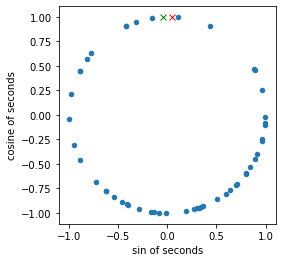

In [7]:
ax1 = df.sample(50).plot.scatter(x='sin_seconds', y='cosine_seconds')
ax1.set_xlabel('sin of seconds')
ax1.set_ylabel('cosine of seconds')

# 10 min after midnight (00:10) # red cross
ax1.plot(
    np.sin(2 * np.pi * 10*60/total_no_of_seconds_in_a_day),
    np.cos(2 * np.pi * 10*60/total_no_of_seconds_in_a_day),
    'xr'
)

# 10 min before  midnight (23:50) # green cross
ax1.plot(
    np.sin(2 * np.pi * ((24*60*60) - (10*60))/total_no_of_seconds_in_a_day),
    np.cos(2 * np.pi * ((24*60*60) - (10*60))/total_no_of_seconds_in_a_day),
    'xg'
)

ax1.set_aspect('equal')
plt.show()
